In [5]:
import sys
ROOT = '/home/lzhou/SAX-NeRF-rho'
sys.path.append(ROOT)

import os
import os.path as osp
import pickle
import time

import torch
from matplotlib import pyplot as plt

In [6]:
from src.config.configloading import load_config
# from src.dataset.tigre import ConeGeometry, TIGREDataset
from src.dataset.tigre_traditional import ConeGeometry

from src.render import matcher 
from src.utils import get_ssim_3d

from image_init import initial_image
import tigre.algorithms as algs

# from leapctype import *
import tigre

# from leapct_bridge import set_leap_from_tigre

torch.cuda.empty_cache()

# device = torch.device("cpu")
device = torch.device("cuda")

In [9]:
task = "foot"
expname = f"{task}_50"

# Config
cfg_dir = os.path.join(ROOT, f"config/FDK/{expname}.yaml")
cfg = load_config(cfg_dir)

datadir = os.path.abspath(osp.join(ROOT, cfg["exp"]["datadir"]))
print("Datadir:", datadir)
with open(datadir, "rb") as handle:
    data = pickle.load(handle)

# del data["imgFDK"]

Datadir: /home/lzhou/SAX-NeRF-rho/data/foot_50.pickle


In [10]:
data["image_init"].keys()

dict_keys(['fdk', 'cgls', 'sirt', 'asd_pocs'])

In [4]:
geo = ConeGeometry(data)
image = data['image']
projs = data['train']['projections']
angles = data['train']['angles']

print(image.shape, projs.shape)

img_fdk = initial_image(projs, geo, angles, algorithm='fdk')
print(img_fdk.shape)
print(f'SSIM', get_ssim_3d(image, img_fdk))

(492, 492, 442) (50, 1024, 1024)
(492, 492, 442)
SSIM 0.5616305984051951


In [ ]:
img_init = initial_image(projs, geo, angles, algorithm='sirt')
print(img_init.shape)

print(f'SSIM-sirt', get_ssim_3d(image, img_init))


(-0.5, 340.5, 340.5, -0.5)

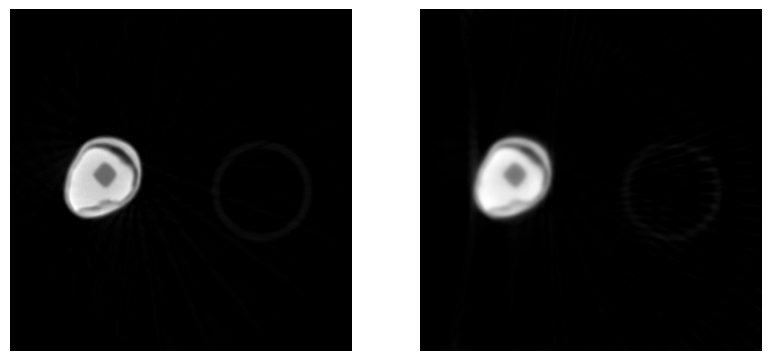

In [7]:
# print(f"projections:{f.shape}")
# print(f"img:{g.shape}, imgFDK:{g.shape}")

ncols, nrows = 3, 1
plt.figure(figsize=(5*ncols, 5*nrows))

idx = 1
plt.subplot(nrows, ncols, idx)
plt.imshow(image[:, :, 50], cmap="gray")
plt.axis('off')    

idx += 1
plt.subplot(nrows, ncols, idx)
plt.imshow(img_init[:, :, 50], cmap="gray")
plt.axis('off')    

# idx += 1
# plt.subplot(nrows, ncols, idx)
# plt.imshow(image_fdk[:, :, 60], cmap="gray")
# plt.axis('off')    


In [5]:
# # algorithms = ['fdk', 'sart', 'asd_pocs', 'cgls']
# algorithms = ['fdk']

# from src.dataset import TIGREDataset as Dataset
# from src.dataset import TIGREDataset_Traditional as Dataset_Traditional


# train_dset = Dataset_Traditional(datadir, cfg["train"]["n_rays"], "train", device) # 由dataset去构造数据集
# # eval_dset = Dataset_Traditional(datadir, cfg["train"]["n_rays"], "val", device)

In [6]:
# data["image_init"] = dict()
# for algo in algorithms:
#     print(f"*[Algo]: {algo}")

#     img_init = initial_image(train_dset, algorithm=algo)
#     data["image_init"][algo] = img_init.copy()

#     img_init = torch.tensor(data["image_init"][algo]).to(device)
#     print(f'--Init: {algo}', get_ssim_3d(train_dset.image, img_init))

    # rhos = matcher(eval_dset.voxels, eval_dset.voxels, img_init, mode="nearest")
    # print(f'--Init matched: {algo}', get_ssim_3d(eval_dset.image, rhos.squeeze()))


# with open(datadir, "wb") as handle:
#     pickle.dump(data, handle)


In [8]:
projs = train_dset.projs.detach().cpu().numpy()
print(projs.dtype)

leapct = set_leap_from_tigre(train_dset.geo)

g = leapct.allocateProjections()        # projections [50, 1024, 1024]
f = leapct.allocateVolume()             # 3d images 

g=projs
leapct.FBP(g,f)
# leapct.SART(g,f,20)
print(f.shape)

float32
ray_weighting::setParkerWeights - Not enough data (need at least 199.333 degrees)!
ray_weighting::setParkerWeights - Not enough data (need at least 199.333 degrees)!
(256, 256, 256)


In [9]:
# Check ./data/

for algo in algorithms:
    print(f"\n*[Algo]: {algo}")
    loss = {
        # "psnr_3d": get_psnr_3d(data['image'], data['image_init'][algo]),
        # "tigre: ssim_3d": get_ssim_3d(data['image'], img_init),
        "ctlib: ssim_3d": get_ssim_3d(data['image'], f),
        }
    print(loss)


*[Algo]: fdk
{'ctlib: ssim_3d': 0.2759386398105908}


projections---f:(512, 512, 463)
img--g:(50, 1024, 1024), imgFDK:(50, 1024, 1024)


(-0.5, 511.5, 511.5, -0.5)

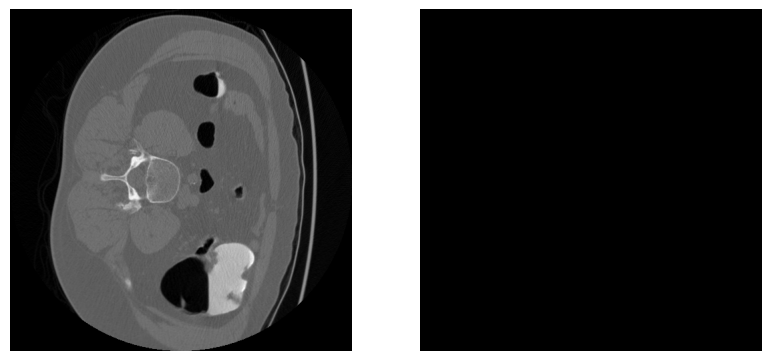

In [10]:
print(f"projections---f:{f.shape}")
print(f"img--g:{g.shape}, imgFDK:{g.shape}")

ncols, nrows = 3, 1
plt.figure(figsize=(5*ncols, 5*nrows))

idx = 1
plt.subplot(nrows, ncols, idx)
plt.imshow(data['image'][:, :, 200], cmap="gray")
plt.axis('off')    

idx += 1
plt.subplot(nrows, ncols, idx)
plt.imshow(f[:, :, 200], cmap="gray")
plt.axis('off')    

# idx += 1
# plt.subplot(nrows, ncols, idx)
# plt.imshow(image_fdk[:, :, 60], cmap="gray")
# plt.axis('off')    
